# 决策树的构造
## 决策树的特点
* 可以处理不熟悉的数据集合
* 可以理解数据中蕴含的知识信息

## 决策树构造的步骤
### Step 1：学习计算信息增益——以熵为例

* 准备数据

In [1]:
def create_dataset():
    dataset = [[1, 1, 'yes'], 
               [1, 1, 'yes'],
               [1, 0, 'no'],
               [0, 1, 'no'],
               [0, 1, 'no']]
    labels = ['no surfacing', 'flippers']
    return dataset, labels

计算给定数据集的熵

计算所有类别所有可能值包含的期望
$H = -\sum_{i = 1}^n p(x_{i})log_{2}p(x_{i})$

其中，$p(x_{i})$是选择该分类概率
$p(x_{i}) = \frac{该类总数}{数据集记录数}$

In [2]:
from math import log


def calc_ent(dataset):
    total_entry = len(dataset)
    label_count = {}
    for feature in dataset:
        cur_label = feature[-1]
#         print(cur_label)
        if cur_label not in label_count.keys():
            label_count[cur_label] = 0
        label_count[cur_label] += 1
    entropy = 0.0
    for key in label_count.keys():
        prob = float(label_count[key]) / total_entry
        entropy -= prob * log(prob, 2)
    return entropy


mydata, label = create_dataset()            
calc_ent(mydata)  

0.9709505944546686

### Step 2：对每个特征划分数据集，度量划分数据集的熵，选取熵最小的特征划分作为本次划分结果
* 划分数据集，提取符合条件的数据，并删除此次判断的属性列

In [3]:
import numpy as np
def split_dataset(dataset, axis, value):
    temp_dataset = []
    for vec in dataset:
        if vec[axis] == value:
            reduce_feature = vec[: axis]
            reduce_feature.extend(vec[axis + 1 :])
            temp_dataset.append(reduce_feature)
    return temp_dataset


mydata, mylabel = create_dataset()
print(split_dataset(mydata, 0, 0))
print(split_dataset(mydata, 0, 1))

[[1, 'no'], [1, 'no']]
[[1, 'yes'], [1, 'yes'], [0, 'no']]


### Step 3：选择最好的分类方式——熵减的集合优先
* 对每一个特征进行以此划分，并且记录熵值，选择熵最小的特征作为划分结果

In [4]:
def choose_feature(dataset):
    total_feature = len(dataset[0]) - 1 # 最后一列为结果集
    base_entrop = calc_ent(dataset)
    best_info_gain = 0.0
    best_feature = -1
    for feature in range(total_feature): # 获取特征值
        feature_list = [vec[feature] for vec in dataset]
        feature_value = set(feature_list)
        temp_prob = 0.0
        for value in feature_value:     # 对同一特征的不同值进行划分
            temp_dataset = split_dataset(dataset, feature, value)
            prob = len(temp_dataset) / float(len(dataset))  # 选择此类别的概率
            prob *= calc_ent(temp_dataset)
            temp_prob += prob
        info_gain = base_entrop - temp_prob
        if info_gain > best_info_gain:
            best_info_gain = info_gain
            best_feature = feature
        print('当前对第%d个特征进行分组，信息增益为%f' %(feature, info_gain))
    return best_feature

choose_feature(mydata)

当前对第0个特征进行分组，信息增益为0.419973
当前对第1个特征进行分组，信息增益为0.170951


0

### Step 4：递归构造决策树——数据集的再划分

In [5]:
def majority_ent(class_list):
    class_count = {}
    for vote in class_list:
        if class_count[vote] == 0:
            class_count[vote] = 0
        class_count[vote] += 1
    sorted_class = sorted(class_count.items(), class_count.itemgetter(1), reverse=True)
    return sorted_class[0][0]


In [6]:
def create_tree(dataset, label, i=0):
    i += 1
    print('第%d次循环' %i)
    class_list = [example[-1] for example in dataset]
    
    if class_list.count(class_list[0]) == len(class_list):
        print('所有的类标签值完全相同，分类结束')
        return class_list[0]
    if len(dataset[0]) == 1:  #标签只剩一个
        print('特征用完，无法再次分类')
        return majority_ent(class_list)
    
    best_feature = choose_feature(dataset)
    print('本次选择的特征为%d，标签为%s' %(best_feature, label[best_feature]))
    
    best_feature_label = label[best_feature]
    desicision_tree = {best_feature_label:{}}
    del(label[best_feature])
    
    feature_value = [example[best_feature] for example in dataset]
    unique_feature = set(feature_value)
    for value in unique_feature:
#         sublabel = label[:]
        desicision_tree[best_feature_label][value] = create_tree(split_dataset(dataset, best_feature, value), label, i)
    
    return desicision_tree

In [7]:
mytree = create_tree(mydata, mylabel)

第1次循环
当前对第0个特征进行分组，信息增益为0.419973
当前对第1个特征进行分组，信息增益为0.170951
本次选择的特征为0，标签为no surfacing
第2次循环
所有的类标签值完全相同，分类结束
第2次循环
当前对第0个特征进行分组，信息增益为0.918296
本次选择的特征为0，标签为flippers
第3次循环
所有的类标签值完全相同，分类结束
第3次循环
所有的类标签值完全相同，分类结束


## 使用matplotlib绘制决策树
* 使用annotate函数进行文本注释

In [8]:
import matplotlib.pyplot as plt
from pylab import *  
mpl.rcParams['font.sans-serif'] = ['SimHei'] 


decision_node = dict(boxstyle='sawtooth', fc='0.8')
leaf_node = dict(boxstyle='round4', fc='0.8')
arrow_args = dict(arrowstyle='<-')

def plot_node(ax, node_txt, center_point, parent_point, node_type):
    ax.annotate(node_txt,
                xy=parent_point, xycoords='axes fraction', 
                xytext=center_point, textcoords='axes fraction', 
                va='center', ha='center', bbox=node_type,
                arrowprops=arrow_args)
    
def create_plot():
    fig = plt.figure(1, facecolor='white')
    fig.clf()
    ax = plt.subplot(111, frameon=False)
    plot_node(ax, '决策节点', (0.5, 0.1), (0.1, 0.5), decision_node)
    plot_node(ax, '叶节点', (0.8, 0.1), (0.3, 0.8), leaf_node)
    plt.show()

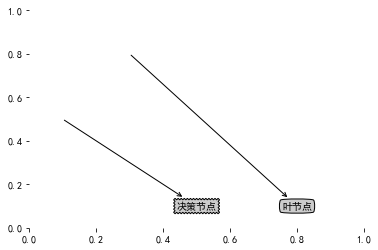

In [9]:
create_plot()

### 绘制注解树的技巧
**我们需要知道：**
* 树的高度——确定y轴长度
* 树的叶子——确定x轴长度

In [10]:
def get_leaf_num(tree):
    num_leaf = 0
    first_str = list(tree.keys())[0]
#     print(list(tree))
    second_dic = tree[first_str]
    for key in second_dic:
        if type(second_dic[key]).__name__ == 'dict':
            num_leaf += get_leaf_num(second_dic[key])
        else:num_leaf += 1
    return num_leaf

In [11]:
get_leaf_num(mytree)

3

In [12]:
def get_tree_depth(tree):
    max_depth = 0
    this_depth = 0
    first_str = list(tree)[0]
    second_dic = tree[first_str]
    for key in second_dic:
        if type(second_dic[key]).__name__ == 'dict':
            this_depth = 1 + get_tree_depth(second_dic[key])
        else: this_depth = 1
        if this_depth > max_depth:
            max_depth = this_depth
    return max_depth

In [13]:
get_tree_depth(mytree)

2

In [14]:
def retrieve_tree(i):
    listOfTrees = [{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}},
                   {'no surfacing': {0: 'no', 1: {'flippers': {0: {'head': {0: 'no', 1: 'yes'}}, 1: 'no'}}}}
                  ]
    return listOfTrees[i]

In [15]:
mytree = retrieve_tree(0)
print(get_leaf_num(mytree))
print(get_tree_depth(mytree))

3
2


### 决策树的绘制 （待补）

### 测试算法：使用决策树进行分类

In [16]:
def classify(tree, feat_label, test_vec):
    first_str = list(tree)[0]
    second_dic = tree[first_str]
    feat_index = feat_label.index(first_str)
    for key in second_dic.keys():
        if test_vec[feat_index] == key:
            if type(second_dic[key]).__name__ == 'dict':
#                 print(second_dic[key])
                class_label = classify(second_dic[key], feat_label, test_vec)
            else:
                print(second_dic[key])
                class_label = second_dic[key]
    return class_label

In [18]:
mydata,label = create_dataset()
mytree = retrieve_tree(0)
classify(mytree, label, [1,0])
classify(mytree, label, [1,1]);

no
yes
